## Amazon Magazine Recommendation System Excluding Metadata Using LightFM

In [1]:
import time
# Marking the initial time
begin = time.time()

In [2]:
# Importing required Libraries
import json
import gzip
import pandas as pd
import numpy as np
from lightfm import LightFM, cross_validation
from lightfm.data import Dataset
from lightfm.evaluation import auc_score
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import random

C:\Users\Bumba\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [21]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
# Loading the product data
data1 = []
with gzip.open('D:\Downloads\meta_Magazine_Subscriptions.json.gz') as f:
    for l in f:
        data1.append(json.loads(l.strip()))
print(len(data1))

3385


In [4]:
# Converting the product data into Pandas dataframe
df1 = pd.DataFrame.from_dict(data1)
print(len(df1))

3385


In [5]:
df1.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat',
       'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes'],
      dtype='object')

In [6]:
# Creating a Product Dataframe with required columns
product_data = df1[['category', 'title', 'brand', 'rank', 'asin']]

In [7]:
# Dropping the duplicate entries
product_data.drop_duplicates(subset=['asin'], keep='first', inplace=True)

In [8]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2320 entries, 0 to 3384
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2320 non-null   object
 1   title     2320 non-null   object
 2   brand     2320 non-null   object
 3   rank      2320 non-null   object
 4   asin      2320 non-null   object
dtypes: object(5)
memory usage: 108.8+ KB


In [9]:
product_data.head()

,category,title,brand,rank,asin
0,"[Magazine Subscriptions, Professional & Educat...","<span class=""a-size-medium a-color-secondary""",Reason Magazine,[],B00005N7NQ
1,"[Magazine Subscriptions, Arts, Music &amp; Pho...","<span class=""a-size-medium a-color-secondary""",String Letter Publishers,742 in Magazine Subscriptions (,B00005N7OC
2,"[Magazine Subscriptions, Fashion &amp; Style, ...","<span class=""a-size-medium a-color-secondary""",Conde Nast Publications,[],B00005N7OD
3,"[Magazine Subscriptions, Sports, Recreation & ...","<span class=""a-size-medium a-color-secondary""",AirAge Publishing,[],B00005N7O9
4,"[Magazine Subscriptions, Professional & Educat...","<span class=""a-size-medium a-color-secondary""",EPG Media & Specialty Information,[],B00005N7O6


In [10]:
# Loading the review data
data2 = []
with gzip.open('D:\Downloads\Magazine_Subscriptions.json.gz') as f:
    for l in f:
        data2.append(json.loads(l.strip()))
print(len(data2))

89689


In [11]:
# Converting the review data into Pandas dataframe
df2 = pd.DataFrame.from_dict(data2)
print(len(df2))

89689


In [12]:
df2.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'style',
       'image'],
      dtype='object')

In [13]:
# Creating a Review Dataframe with required columns
review_data = df2[['overall', 'reviewerID', 'asin']]

In [14]:
# Removing the duplicate reviews given by a particular user to a particular product
review_data.drop_duplicates(subset=['reviewerID', 'asin'], keep='first', inplace=True)

In [15]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88318 entries, 0 to 89688
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     88318 non-null  float64
 1   reviewerID  88318 non-null  object 
 2   asin        88318 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.7+ MB


In [16]:
review_data.head()

,overall,reviewerID,asin
0,5.0,AH2IFH762VY5U,B00005N7P0
1,5.0,AOSFI0JEYU4XM,B00005N7P0
2,3.0,A3JPFWKS83R49V,B00005N7OJ
3,5.0,A19FKU6JZQ2ECJ,B00005N7OJ
4,5.0,A25MDGOMZ2GALN,B00005N7P0


array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

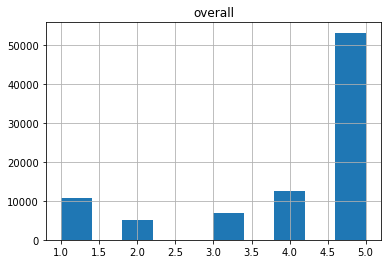

In [18]:
review_data.hist(column='overall')

In [17]:
# Now creating a new dataframe by merging the review dataframe and product dataframe 
final = review_data.merge(product_data, how='left', left_on='asin', right_on='asin')

In [18]:
final.head()

,overall,reviewerID,asin,category,title,brand,rank
0,5.0,AH2IFH762VY5U,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[]
1,5.0,AOSFI0JEYU4XM,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[]
2,3.0,A3JPFWKS83R49V,B00005N7OJ,"[Magazine Subscriptions, Home & Garden, Antiqu...","<span class=""a-size-medium a-color-secondary""",Brant Publications,406 in Magazine Subscriptions (
3,5.0,A19FKU6JZQ2ECJ,B00005N7OJ,"[Magazine Subscriptions, Home & Garden, Antiqu...","<span class=""a-size-medium a-color-secondary""",Brant Publications,406 in Magazine Subscriptions (
4,5.0,A25MDGOMZ2GALN,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[]


In [19]:
final.dropna(axis=0, how='any', inplace=True)

In [20]:
# Now converting User IDs and Product IDs from String type to Numeric type and storing them into new columns
le = preprocessing.LabelEncoder()
final['user']= le.fit_transform(final['reviewerID'])
final['product']= le.fit_transform(final['asin'])

In [21]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83993 entries, 0 to 88315
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     83993 non-null  float64
 1   reviewerID  83993 non-null  object 
 2   asin        83993 non-null  object 
 3   category    83993 non-null  object 
 4   title       83993 non-null  object 
 5   brand       83993 non-null  object 
 6   rank        83993 non-null  object 
 7   user        83993 non-null  int32  
 8   product     83993 non-null  int32  
dtypes: float64(1), int32(2), object(6)
memory usage: 5.8+ MB


In [22]:
final.head()

,overall,reviewerID,asin,category,title,brand,rank,user,product
0,5.0,AH2IFH762VY5U,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[],58923,13
1,5.0,AOSFI0JEYU4XM,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[],62889,13
2,3.0,A3JPFWKS83R49V,B00005N7OJ,"[Magazine Subscriptions, Home & Garden, Antiqu...","<span class=""a-size-medium a-color-secondary""",Brant Publications,406 in Magazine Subscriptions (,46120,9
3,5.0,A19FKU6JZQ2ECJ,B00005N7OJ,"[Magazine Subscriptions, Home & Garden, Antiqu...","<span class=""a-size-medium a-color-secondary""",Brant Publications,406 in Magazine Subscriptions (,4781,9
4,5.0,A25MDGOMZ2GALN,B00005N7P0,"[Magazine Subscriptions, Technology, Computers...","<span class=""a-size-medium a-color-secondary""","Future US, Inc.",[],21011,13


In [23]:
# Fitting the User IDs and Product IDs into LightFM Library in-built Dataset function
dataset = Dataset(user_identity_features=False)
dataset.fit(set(final['user']), set(final['product']))

In [24]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(68482, 2320)

In [25]:
# Generating the user-product interactions and interaction-weights
(interactions, weights) = dataset.build_interactions(((final['user'][i], final['product'][i]) for i in final.index))

In [26]:
# Fitting the dataset into model
model = LightFM(
    no_components=150,
    learning_rate=0.05,
    loss='warp',
    random_state=13)

model.fit(
    interactions,
    sample_weight=weights,
    epochs=5, num_threads=4, verbose=True)

Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


In [27]:
# Checking the auc score
auc_score(model, interactions).mean()

0.99121463

In [28]:
# AUC score is 0.99, which is excellent

In [29]:
# Creating a fuction to generate recommendation
def recommend_softwares(userid, num_reco=5):
    reviewed_product_id = final.loc[final['reviewerID'] == userid]['product'].values.tolist()
    prediction = final.loc[~final['product'].isin(reviewed_product_id)]
    target = prediction['product'].values.tolist()
    target_id = int(final['user'][final.loc[final['reviewerID'] == userid].index[0]])
    scores = model.predict(target_id, target)
    prediction['scores'] = scores
    prediction = prediction.sort_values(by='scores', ascending=False)
    prediction.drop_duplicates(subset=['product'], inplace=True)
    print("Here are the top {} recommendations for user {}".format(num_reco, userid))
    return prediction[['title', 'brand', 'category', 'asin']][:num_reco]

In [30]:
# Selecting a random user to generate recommendation for that user
p = final['reviewerID'].unique()
a = random.choice(p)

In [31]:
recommend_softwares(a)

Here are the top 5 recommendations for user ATJE4594UFWXA


,title,brand,category,asin
35847,"<span class=""a-size-medium a-color-secondary""","Trusted Media Brands, Inc","[Magazine Subscriptions, Literary, Sci-Fi & My...",B00007B10Y
73697,"<span class=""a-size-medium a-color-secondary""",Conde Nast Publications,"[Magazine Subscriptions, Science, History &amp...",B00005N7TL
21802,"<span class=""a-size-medium a-color-secondary""",National Geographic Partners LLC,"[Magazine Subscriptions, Professional & Educat...",B00005NIOH
53945,"<span class=""a-size-medium a-color-secondary""",TV Guide,"[Magazine Subscriptions, Entertainment &amp; P...",B000IOEJ8W
2495,"<span class=""a-size-medium a-color-secondary""","Trusted Media Brands, Inc","[Magazine Subscriptions, Home & Garden, How-to...",B00005N7Q1


In [32]:
# Marking the end time
end = time.time()
# Calculating the executing time
print("Total time taken {} minutes".format((end-begin)//60))

Total time taken 2.0 minutes
